# Loading libraries

In [2]:
# DANGER: only run 1x otherwise will chdir too many times
import sys
import os
import yaml

sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
import optuna

from darts import models, metrics, TimeSeries
from darts.dataprocessing.transformers import Scaler

from data_formatter.base import * # TODO: inefficient

# Check statistics of the data

In [15]:
# load yaml config file
with open('./config/iglu.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set interpolation params for no interpolation
new_config = config.copy()
new_config['interpolation_params']['gap_threshold'] = 30
new_config['interpolation_params']['min_drop_length'] = 0
# set split params for no splitting
new_config['split_params']['test_percent_subjects'] = 0
new_config['split_params']['length_segment'] = 0
# set scaling params for no scaling
new_config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 0
	Extracted segments: 39
	Interpolated values: 697
	Percent of values interpolated: 4.90%
Splitting data...
	Train: 14226 (100.00%)
	Val: 0 (0.00%)
	Test: 0 (0.00%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


In [32]:
%%capture

# Need: Tradeoff between interpolation and segment length
# Problem: Manually tuning is slow and potentially imprecise
# Idea: have automated function that can help determine what the gap threshold should be
# Proof of concept below

import numpy as np

def calc_percent(a, b):
    return a*100/b

gap_threshold = np.arange(5, 70, 1)
percent_valid = []
for i in gap_threshold:
    new_config['interpolation_params']['gap_threshold'] = i
    df = DataFormatter(new_config).train_data
    
    segment_lens = []
    for group, data in df.groupby('id_segment'):
        segment_lens.append(len(data))
    
    threshold = 240
    valid_ids = df.groupby('id_segment')['time'].count().loc[lambda x : x>threshold].reset_index()['id_segment']
    
    percent_valid.append((len(valid_ids)*100/len(segment_lens)))

Text(0.5, 0, 'Gap Threshold (min)')

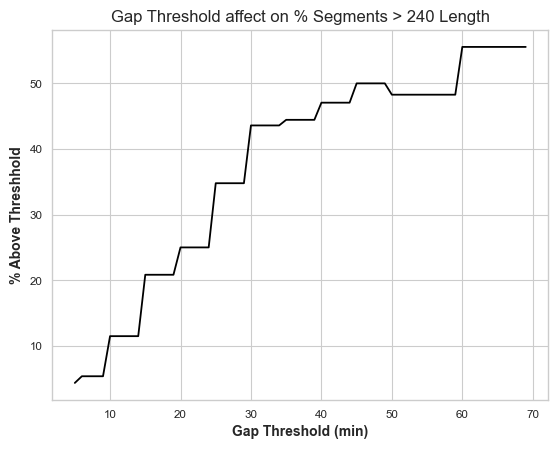

In [35]:
# Plot results
plt.plot(gap_threshold, percent_valid)
plt.title("Gap Threshold affect on % Segments > 240 Length")
plt.ylabel("% Above Threshhold")
plt.xlabel("Gap Threshold (min)")

Train segment lengths:
	Min:  1
	Max:  1696
	Median:  208.0
	Mean:  364.7692307692308
	Std:  433.04121089719126


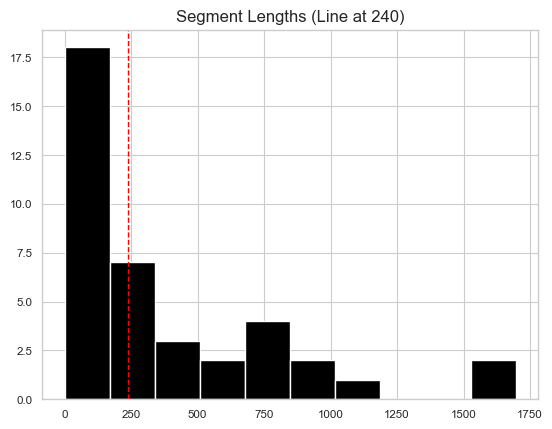

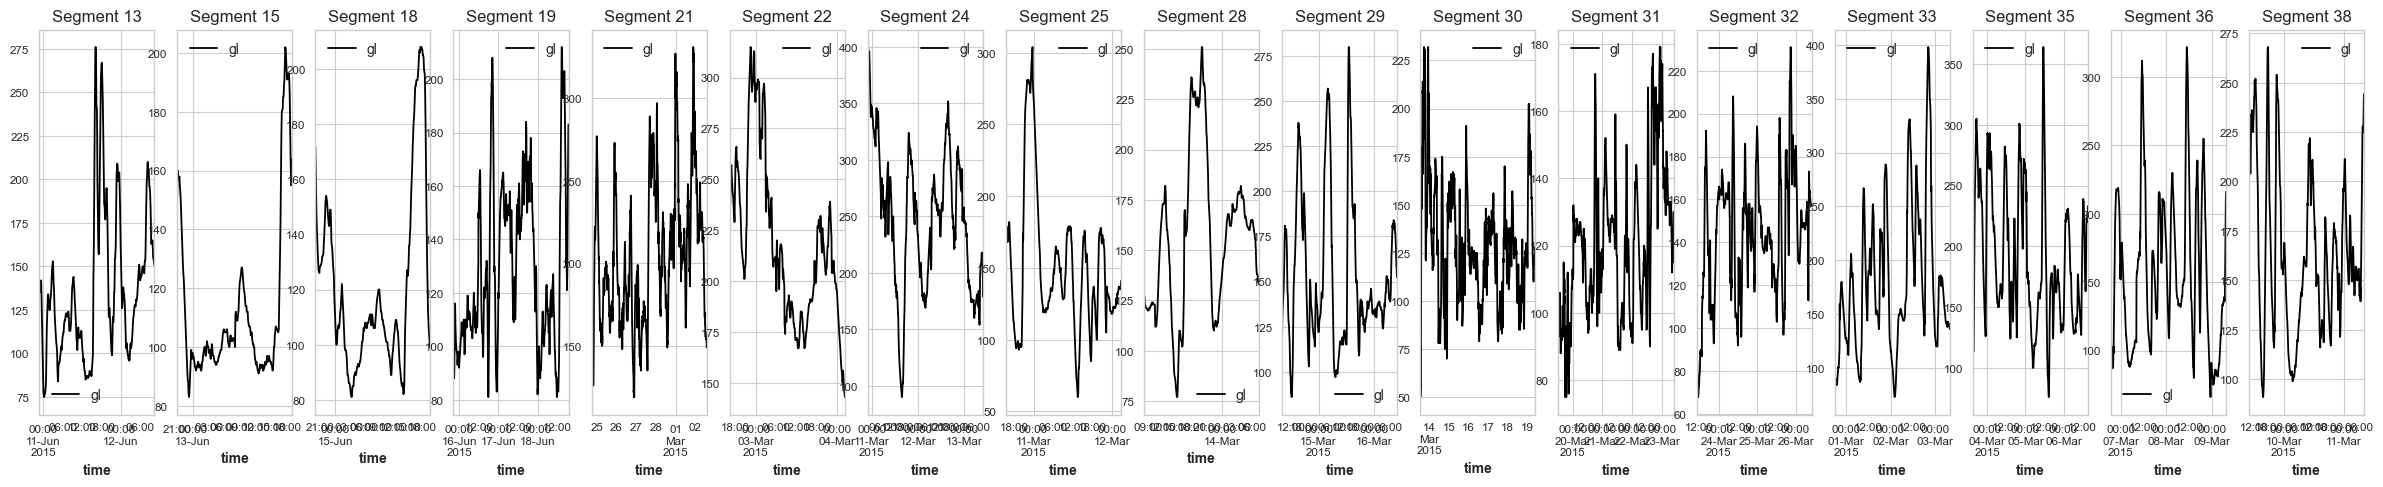

In [36]:
# print min, max, median, mean, std of segment lengths
df = formatter.train_data
segment_lens = []
for group, data in df.groupby('id_segment'):
    segment_lens.append(len(data))

print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\tMedian: ', np.median(segment_lens))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# Visualize segment lengths to see approx # of valid ones (>240)
plt.title("Segment Lengths (Line at 240)")
plt.hist(segment_lens)
plt.axvline(240, color='r', linestyle='dashed', linewidth=1)

# filter to get valid indices
threshold = 240
valid_ids = df.groupby('id_segment')['time'].count().loc[lambda x : x>threshold].reset_index()['id_segment']
df_filtered = df.loc[df['id_segment'].isin(valid_ids)]

# plot each segment
num_segments = df_filtered['id_segment'].nunique()

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(df_filtered.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))

In [12]:
df.head(10)

,time,id,gl,time_year,time_month,time_day,time_hour,time_minute,id_segment
0,2015-06-06 16:50:00,0.0,153.0,2015.0,6.0,6.0,16.0,50.0,0
1,2015-06-06 17:05:00,0.0,137.0,2015.0,6.0,6.0,17.0,5.0,1
2,2015-06-06 17:10:00,0.0,128.0,2015.0,6.0,6.0,17.0,10.0,2
3,2015-06-06 17:15:00,0.0,121.0,2015.0,6.0,6.0,17.0,15.0,3
4,2015-06-06 17:25:00,0.0,120.0,2015.0,6.0,6.0,17.0,25.0,4
5,2015-06-06 17:45:00,0.0,138.0,2015.0,6.0,6.0,17.0,45.0,5
6,2015-06-06 17:55:00,0.0,155.0,2015.0,6.0,6.0,17.0,55.0,6
7,2015-06-06 18:05:00,0.0,159.0,2015.0,6.0,6.0,18.0,5.0,7
8,2015-06-06 18:25:00,0.0,154.0,2015.0,6.0,6.0,18.0,25.0,8
9,2015-06-06 18:30:00,0.0,152.0,2015.0,6.0,6.0,18.0,30.0,9


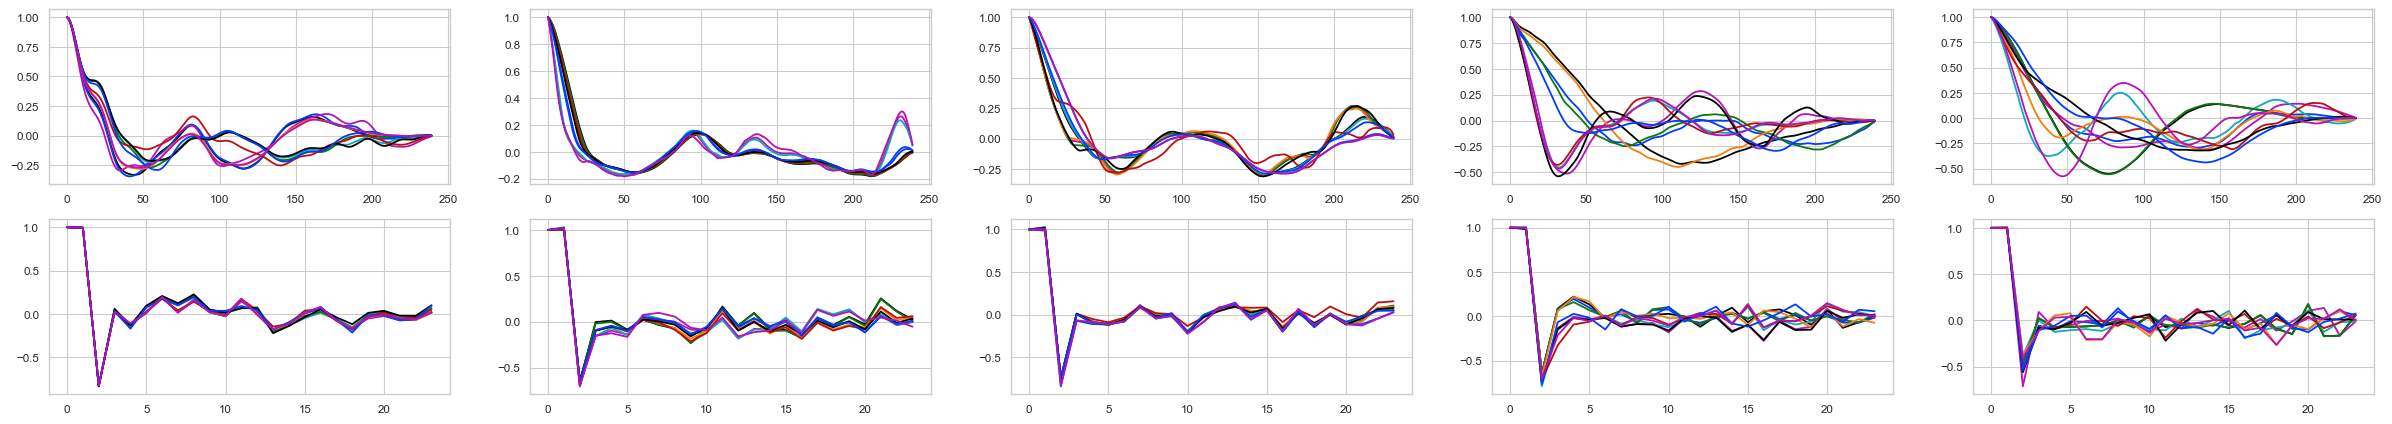

In [38]:
# plot acf of random samples from segments
fig, ax = plt.subplots(2, 5, figsize=(30, 5))
lags = 240
for i, (group, data) in enumerate(df_filtered.groupby('id_segment')):
    # only view top 5
    if i < 5:
        data = data['gl']
        if len(data) < lags: # TODO: Could probably do filtering in pandas which would be faster
            print('Segment {} is too short'.format(group))
            continue
        # select 10 random samples from index of data
        sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
        # plot acf / pacf of each sample
        for j in sample:
            acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
            pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
            ax[0, i].plot(acf)
            ax[1, i].plot(pacf)


# Change the config according to the observations above

In [39]:
# set interpolation params for no interpolation
config['interpolation_params']['gap_threshold'] = 30
config['interpolation_params']['min_drop_length'] = 240
# set split params for no splitting
config['split_params']['test_percent_subjects'] = 0.1
config['split_params']['length_segment'] = 240
# set scaling params for no scaling
config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 22
	Extracted segments: 17
	Interpolated values: 513
	Percent of values interpolated: 4.10%
Splitting data...
	Train: 6902 (61.50%)
	Val: 2400 (21.39%)
	Test: 3220 (28.69%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


# Program the model

## Convert data and (optional) scaling

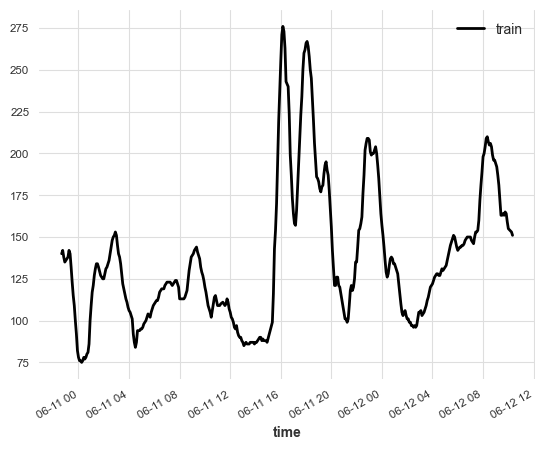

In [14]:
# build target series
target_col = formatter.get_column('target')
time_col = formatter.get_column('time')
group_col = formatter.get_column('sid')
train_series = TimeSeries.from_group_dataframe(formatter.train_data, 
                                               group_cols = group_col, 
                                               time_col = time_col, 
                                               value_cols = target_col)
val_series = TimeSeries.from_group_dataframe(formatter.val_data,
                                             group_cols = group_col,
                                             time_col = time_col,
                                             value_cols = target_col)
test_series = TimeSeries.from_group_dataframe(formatter.test_data,
                                              group_cols = group_col,
                                              time_col = time_col,
                                              value_cols = target_col)

# build static covariates series
static_cols = formatter.get_column('static_covs')
if static_cols is not None:
    static_cols += [formatter.get_column('id')]
else:
    static_cols = [formatter.get_column('id')]
train_static = TimeSeries.from_group_dataframe(formatter.train_data, 
                                               group_cols = group_col, 
                                               time_col = time_col, 
                                               value_cols = static_cols)
val_static = TimeSeries.from_group_dataframe(formatter.val_data,
                                             group_cols = group_col,
                                             time_col = time_col,
                                             value_cols = static_cols)
test_static = TimeSeries.from_group_dataframe(formatter.test_data,
                                              group_cols = group_col,
                                              time_col = time_col,
                                              value_cols = static_cols)

# build dynamic covariates series
dynamic_cols = formatter.get_column('dynamic_covs')
if dynamic_cols is not None:
    train_dynamic = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                    group_cols = group_col, 
                                                    time_col = time_col, 
                                                    value_cols = dynamic_cols)
    val_dynamic = TimeSeries.from_group_dataframe(formatter.val_data,
                                                  group_cols = group_col,
                                                  time_col = time_col,
                                                  value_cols = dynamic_cols)
    test_dynamic = TimeSeries.from_group_dataframe(formatter.test_data,
                                                   group_cols = group_col,
                                                   time_col = time_col,
                                                   value_cols = dynamic_cols)

# build future covariates series
future_cols = formatter.get_column('future_covs')
if future_cols is not None:
    train_future = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                   group_cols = group_col, 
                                                   time_col = time_col, 
                                                   value_cols = future_cols)
    val_future = TimeSeries.from_group_dataframe(formatter.val_data,
                                                 group_cols = group_col,
                                                 time_col = time_col,
                                                 value_cols = future_cols)
    test_future = TimeSeries.from_group_dataframe(formatter.test_data,
                                                  group_cols = group_col,
                                                  time_col = time_col,
                                                  value_cols = future_cols)

train_series[0].plot(label='train')

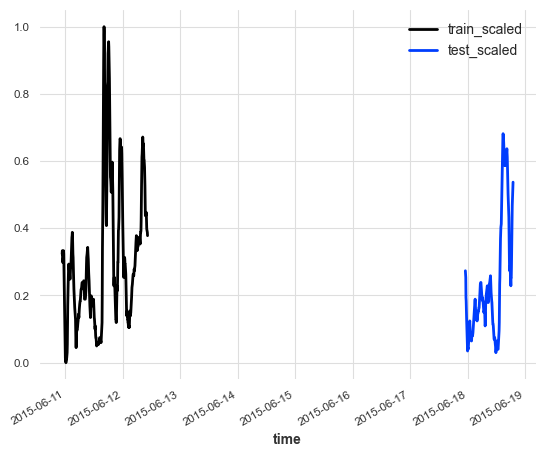

In [15]:
# scale the data
scaler = Scaler()
scaler.fit(train_series)
train_series_scaled = scaler.transform(train_series)
val_series_scaled = scaler.transform(val_series)
test_series_scaled = scaler.transform(test_series)

# scale covariates
scaler_static = Scaler()
if static_cols is not None:
    scaler_static.fit(train_static)
    train_static_scaled = scaler_static.transform(train_static)
    val_static_scaled = scaler_static.transform(val_static)
    test_static_scaled = scaler_static.transform(test_static)

# scale dynamic covariates
scaler_dynamic = Scaler()
if dynamic_cols is not None:
    scaler_dynamic.fit(train_dynamic)
    train_dynamic_scaled = scaler_dynamic.transform(train_dynamic)
    val_dynamic_scaled = scaler_dynamic.transform(val_dynamic)
    test_dynamic_scaled = scaler_dynamic.transform(test_dynamic)

# scale future covariates
scaler_future = Scaler()
if future_cols is not None:
    scaler_future.fit(train_future)
    train_future_scaled = scaler_future.transform(train_future)
    val_future_scaled = scaler_future.transform(val_future)
    test_future_scaled = scaler_future.transform(test_future)

train_series_scaled[0].plot(label='train_scaled')
test_series_scaled[0].plot(label='test_scaled')

## ARIMA model

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
arima = models.ARIMA(p=1, d=1, q=1, seasonal_order=(0, 0, 0, 0))
forecasts = arima.historical_forecasts(val_series_scaled, 
                                       train_length=156,
                                       forecast_horizon=12,
                                       stride=1,
                                       retrain=True,
                                       last_points_only=True,
                                       verbose=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

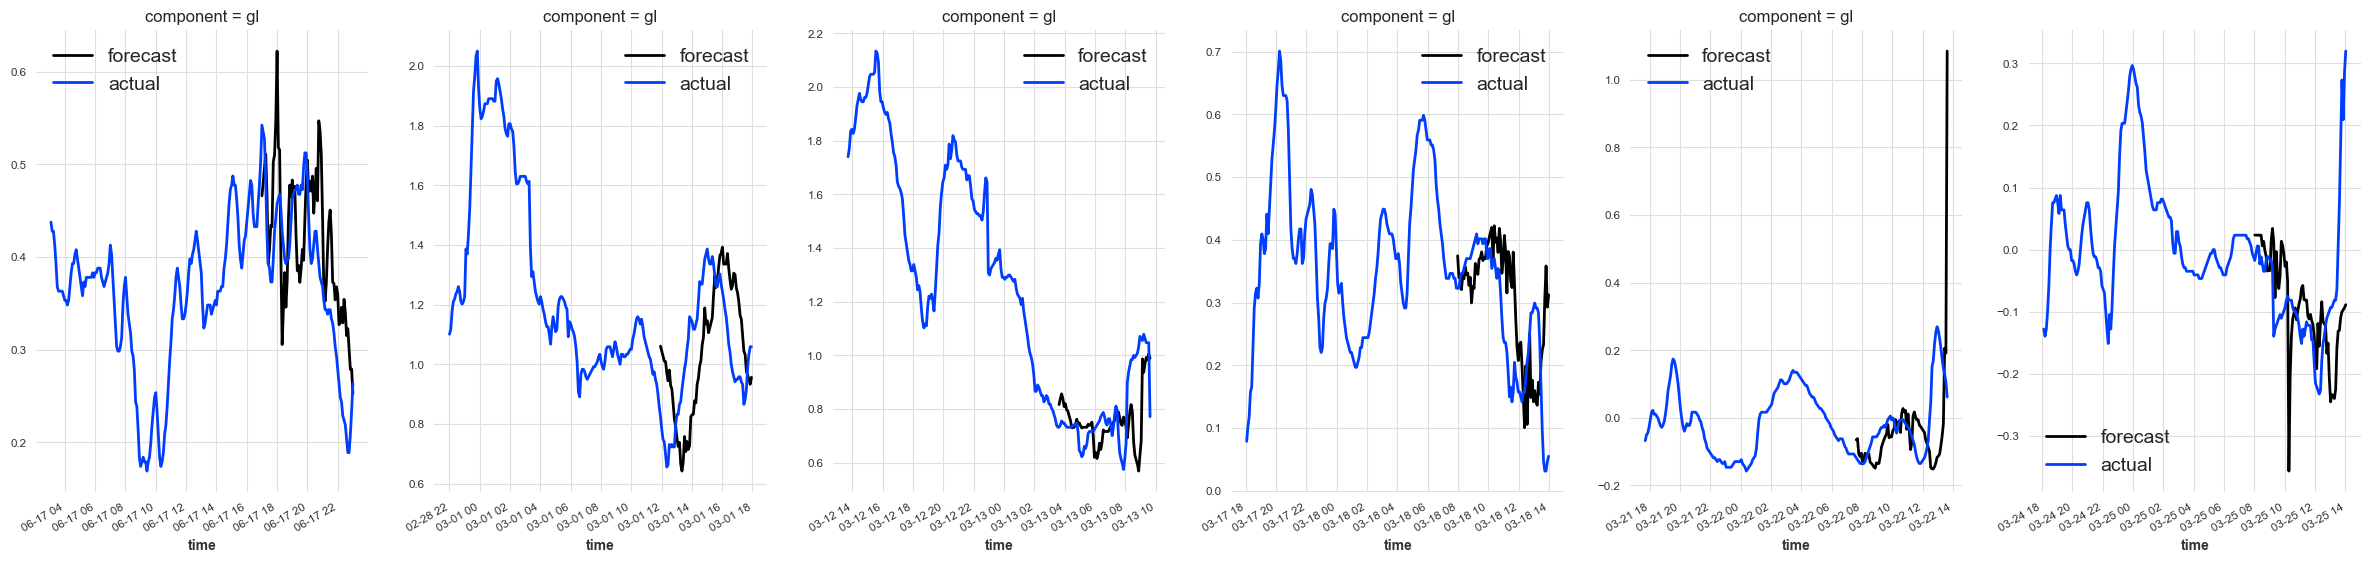

In [18]:
fig, axs = plt.subplots(1, 6, figsize=(30, 6))
for i in range(6):
    forecasts[i].plot(label='forecast', ax=axs[i])
    val_series_scaled[i].plot(label='actual', ax=axs[i])
    axs[i].legend(fontsize=14)

In [ ]:
arima = models.ARIMA()

# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 100, 192)
    out_len = 12

    # Hyperparameters
    p = trial.suggest_int("p", 1, 5) # AR terms
    d = trial.suggest_int("d", 1, 5) # Order of differencing
    q = trial.suggest_int("q", 1, 5) # MA terms

    # build the TCN model
    model = models.ARIMA(
        p=p, d=d, q=q,
        seasonal_order=(0, 0, 0, 0)
    )

    # backtest on the validation set
    errors = model.backtest(val_series_scaled,
                            train_length=in_len,
                            forecast_horizon=out_len,
                            stride=1,
                            retrain=True,
                            verbose=False,
                            metric=metrics.rmse,
                            last_points_only=False,
                            )
    avg_error = np.mean(errors)

    return avg_error


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the rmse on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])


[I 2023-02-05 11:24:31,941] A new study created in memory with name: no-name-7d757b4b-329d-43a1-8f48-6cad5826cf66
[I 2023-02-05 11:32:29,140] Trial 0 finished with value: 0.20587072116315208 and parameters: {'in_len': 182, 'p': 2, 'd': 4, 'q': 4}. Best is trial 0 with value: 0.20587072116315208.


Current value: 0.20587072116315208, Current params: {'in_len': 182, 'p': 2, 'd': 4, 'q': 4}
Best value: 0.20587072116315208, Best params: {'in_len': 182, 'p': 2, 'd': 4, 'q': 4}


[I 2023-02-05 12:48:28,346] Trial 1 finished with value: 0.15954950750558625 and parameters: {'in_len': 112, 'p': 4, 'd': 3, 'q': 3}. Best is trial 1 with value: 0.15954950750558625.


Current value: 0.15954950750558625, Current params: {'in_len': 112, 'p': 4, 'd': 3, 'q': 3}
Best value: 0.15954950750558625, Best params: {'in_len': 112, 'p': 4, 'd': 3, 'q': 3}


[I 2023-02-05 12:55:00,405] Trial 2 finished with value: 0.1417873747680994 and parameters: {'in_len': 192, 'p': 5, 'd': 2, 'q': 4}. Best is trial 2 with value: 0.1417873747680994.


Current value: 0.1417873747680994, Current params: {'in_len': 192, 'p': 5, 'd': 2, 'q': 4}
Best value: 0.1417873747680994, Best params: {'in_len': 192, 'p': 5, 'd': 2, 'q': 4}
